# Introduccion

La encuesta nacional de programas presupuestales permita procesar información de diferentes programas presupuestales que se vienen implementando a nivel nacional; y servir de base para el diseño y orientación de políticas públicas para el mejoramiento de las condiciones de vida de la población.

<img src='https://cdn.www.gob.pe/uploads/campaign/photo/000/008/603/ENAPRES.jpg'>

Para este trabajo, se emplearán 2 datasets asociados a 2 módulos de la encuesta:
* 1. Características de la vivienda y el hogar
* 2. Características de los residentes habituales del hogar
 
**El obtetivo se centrará en análizar las variables más importantes que permitan conocer la situación de los servicios de agua y alcantarillado**

* Cobertura de agua y alcantarillado
* Cloración
* Continudad del servicio

# Limpieza y transformación de datos

In [334]:
# Instalando librería necesaria para utilizar el factor de expansión
!pip install weightedcalcs

In [335]:
# Importante librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import weightedcalcs as wc
import warnings
warnings.filterwarnings("ignore") #Ignorando los warnings

In [336]:
# Cargando datasets
bd_hogar = pd.read_csv('../data/CAP_100_URBANO_RURAL_3.csv',encoding='latin-1',sep=';')
bd_poblacion = pd.read_csv('../data/CAP_200_URBANO_RURAL_4.csv',encoding='latin-1',sep=';')

In [337]:
# Dimensión de la data
print("Número de hogares: "+str(bd_hogar.shape[0]))
print("Número de residentes: "+str(bd_poblacion.shape[0]))

Número de hogares: 42000
Número de residentes: 147007


In [338]:
# Visualización de registro de la base de hogares
bd_hogar.head()

,ANIO,MES,CONGLOMERADO,VIVIENDA,HOGAR,PER,NSELV,TSELV,VIVREM,NUMVIVREM,...,P189_3,P189_4,P189_5,P189_6,P189_7,P189_8,P189_8_O,REGIONNATU,ESTRATO,FACTOR
0,2023,1,55,2,1,1,32,1,2,,...,,,,,,,,1,2,"76,1065448790511"
1,2023,1,55,3,1,1,56,1,2,,...,,,,,,,,1,2,"76,1065448790511"
2,2023,1,55,6,1,1,102,1,2,,...,,,,,,,,1,2,"76,1065448790511"
3,2023,1,55,10,1,1,77,1,1,15,...,,,,,,,,1,2,"76,1065448790511"
4,2023,1,55,11,1,1,114,1,1,90,...,,,,,,,,1,2,"76,1065448790511"


In [339]:
# Visualización de registro de la base de población
bd_poblacion.head()

,ANIO,MES,CONGLOMERADO,VIVIENDA,HOGAR,P201,PER,NSELV,TSELV,VIVREM,...,P206,P207,P208_A,P208_B,P211A,P217A,P218,REGIONNATU,ESTRATO,FACTOR
0,2023,1,55,2,1,1,1,32,1,2,...,,1,52,,3,0,0,1,2,"76,1065448790511"
1,2023,1,55,2,1,2,1,32,1,2,...,,2,47,,3,0,0,1,2,"76,1065448790511"
2,2023,1,55,2,1,3,1,32,1,2,...,,2,9,,,,,1,2,"76,1065448790511"
3,2023,1,55,2,1,4,1,32,1,2,...,,1,24,,4,1,1,1,2,"76,1065448790511"
4,2023,1,55,2,1,5,1,32,1,2,...,,2,2,,,,,1,2,"76,1065448790511"


In [340]:
# Tranformación y filtro de datos (BD Poblacion)

# - Variables
# P204: ¿Es miembro del hogar?     1: Si, 2: No
# P205: ¿Se encuentra ausente del hogar 6 meses o más?    1: Si, 2: No
# P206: ¿Está presenten en el hogar 6 meses o más?   1: Si, 2: No

# -Verificando los tipos de datos
print("Tipos de datos de variables P204, P205 y P206")
print("----------")
print(bd_poblacion[['P204','P205','P206']].dtypes)
bd_poblacion_completa = bd_poblacion[((bd_poblacion.P204 == 1) & (bd_poblacion.P205 == '2')) |
 ((bd_poblacion.P204 == 2) & (bd_poblacion.P206 == '1'))]

# El factor de expanción tiene un formato errónes y por eso es un tipo de dato 'object'
print("Tipo de dato de la variable FACTOR")
print("----------")
print(bd_poblacion_completa.FACTOR.dtypes)

print(bd_poblacion_completa.FACTOR[:5])
print("----------")
 # Convirtiendo el tipo de dato de la variable FACTOR a float
bd_poblacion_completa['FACTOR'] = bd_poblacion_completa['FACTOR'].str.replace(",",".").astype(float)
print(bd_poblacion_completa.FACTOR[:5])

# Seleccionando las columnas finales
bd_poblacion_completa = bd_poblacion_completa[['CONGLOMERADO','VIVIENDA','HOGAR','PER','MES','P201']]

Tipos de datos de variables P204, P205 y P206
----------
P204     int64
P205    object
P206    object
dtype: object
Tipo de dato de la variable FACTOR
----------
object
0    76,1065448790511
1    76,1065448790511
2    76,1065448790511
3    76,1065448790511
4    76,1065448790511
Name: FACTOR, dtype: object
----------
0    76.106545
1    76.106545
2    76.106545
3    76.106545
4    76.106545
Name: FACTOR, dtype: float64


In [341]:
# Tranformación y filtro de datos (BD Hogar)

# - Acceso a agua por red pública  (1: Con acceso    2: Sin acceso)
bd_hogar['AGUA_RPA'] = bd_hogar["P129G"].apply(lambda x: 1 if x<=3
                                  else 2 if x!=1
                                  else None)
# - Acceso a alcantaillado por red pública  (1: Con acceso    2: Sin acceso)
bd_hogar['ALCA_RPA'] = bd_hogar["P142A"].apply(lambda x: 1 if x<=2
                                  else 2 if x!=1
                                  else None)

# - Cloro residual (ejm: 0.05)
bd_hogar['CLORO_RESIDUAL'] = bd_hogar['P129D_ENT'].replace(' ',np.nan).astype(float) + \
    bd_hogar['P129D_DEC'].replace(' ',np.nan).astype(float)*0.1

# - Cloro adecuado (1: Cloro adecuado   2: Cloro inadecuado)
bd_hogar['NIVEL_CLORO_RESIDUAL'] = bd_hogar["CLORO_RESIDUAL"].apply(lambda x: 1 if x>=0.5
                                  else 2 if x<0.5
                                  else None)

# - Filtrando resultado final de la encuesta (1: Completa    2: Incompleta)
bd_hogar = bd_hogar[bd_hogar.RESFIN == 1]

# - Reemplazando nulos y transformando tipos de dato
bd_hogar['P130Z'] = bd_hogar['P130Z'].replace(' ',np.nan).apply(lambda x: int(x) if not pd.isna(x) else x)
bd_hogar['P130ZA'] = bd_hogar['P130ZA'].replace(' ',np.nan).apply(lambda x: float(x) if not pd.isna(x) else x)
bd_hogar['CLORO_RESIDUAL'] = bd_hogar['CLORO_RESIDUAL'].replace(' ',np.nan).apply(lambda x: float(x) if not pd.isna(x) else x)

# - Renombrando columnas
bd_hogar.rename(columns={'P130Z':'AGUA_TODOS_LOS_DIAS','P130ZA':'NUM_HORAS'},inplace=True)

bd_hogar_completa = bd_hogar[['PER','MES','CONGLOMERADO','VIVIENDA','HOGAR','AREA','NOMBREDD','REGIONNATU','ESTRATO'
                              ,'FACTOR','AGUA_TODOS_LOS_DIAS','NUM_HORAS','AGUA_RPA','ALCA_RPA',
                              'CLORO_RESIDUAL','NIVEL_CLORO_RESIDUAL']]

bd_hogar_completa['FACTOR'] = bd_hogar_completa['FACTOR'].str.replace(",",".").astype(float)



In [342]:
# Uniendo las bases a nivel de hogar y población
bd_enapres_completa = pd.merge(bd_poblacion_completa,bd_hogar_completa,
                               on=['CONGLOMERADO','VIVIENDA','HOGAR','PER','MES'],how="inner").drop(
    columns=['CONGLOMERADO','VIVIENDA','HOGAR','PER','MES','P201']
                               )

In [343]:
# Etiquetando variables
region = {1:"COSTA",2:"SIERRA",3:"SELVA"}
area = {1:"URBANO",2:"RURAL"}
estrato = {'1':"A",'2':"B",'3':"C",'4':"D",'5':"E"}
lab_si_no = {1:"SI",2:"NO"}

bd_enapres_completa['REGIONNATU_LAB'] = bd_enapres_completa['REGIONNATU'].map(region)
bd_enapres_completa['ESTRATO_LAB'] = bd_enapres_completa['ESTRATO'].map(estrato)
bd_enapres_completa['AREA_LAB'] = bd_enapres_completa['AREA'].map(area)
bd_enapres_completa['AGUA_TODOS_LOS_DIAS_LAB'] = bd_enapres_completa['AGUA_TODOS_LOS_DIAS'].map(lab_si_no)
bd_enapres_completa['AGUA_RPA_LAB'] = bd_enapres_completa['AGUA_RPA'].map(lab_si_no)
bd_enapres_completa['ALCA_RPA_LAB'] = bd_enapres_completa['ALCA_RPA'].map(lab_si_no)
bd_enapres_completa['NIVEL_CLORO_RESIDUAL_LAB'] = bd_enapres_completa['NIVEL_CLORO_RESIDUAL'].map(lab_si_no)

In [344]:
bd_enapres_completa.head()

,AREA,NOMBREDD,REGIONNATU,ESTRATO,FACTOR,AGUA_TODOS_LOS_DIAS,NUM_HORAS,AGUA_RPA,ALCA_RPA,CLORO_RESIDUAL,NIVEL_CLORO_RESIDUAL,REGIONNATU_LAB,ESTRATO_LAB,AREA_LAB,AGUA_TODOS_LOS_DIAS_LAB,AGUA_RPA_LAB,ALCA_RPA_LAB,NIVEL_CLORO_RESIDUAL_LAB
0,1,TUMBES,1,2,76.106545,1.0,24.0,1,1,0.6,1.0,COSTA,B,URBANO,SI,SI,SI,SI
1,1,TUMBES,1,2,76.106545,1.0,24.0,1,1,0.6,1.0,COSTA,B,URBANO,SI,SI,SI,SI
2,1,TUMBES,1,2,76.106545,1.0,24.0,1,1,0.6,1.0,COSTA,B,URBANO,SI,SI,SI,SI
3,1,TUMBES,1,2,76.106545,1.0,24.0,1,1,0.6,1.0,COSTA,B,URBANO,SI,SI,SI,SI
4,1,TUMBES,1,2,76.106545,1.0,24.0,1,1,0.6,1.0,COSTA,B,URBANO,SI,SI,SI,SI


# Análisis exploratorio

In [345]:
# Instanciando objeto
peso = wc.Calculator("FACTOR")

In [361]:
# Calculando el porcentaje de acceso a agua por área de residencia
acceso_agua = peso.distribution(bd_enapres_completa.groupby(['AREA_LAB']),'AGUA_RPA_LAB').drop('NO',axis=1)
acceso_agua['SI'] = round(acceso_agua['SI']*100,1)
print("----------")
print("Acceso a agua por área")
print(acceso_agua)

# Calculando el porcentaje de acceso a alcantarillado por área de residencia
acceso_alca = peso.distribution(bd_enapres_completa.groupby(['AREA_LAB']),'ALCA_RPA_LAB').drop('NO',axis=1)
acceso_alca['SI'] = round(acceso_alca['SI']*100,1)
print("----------")
print("Acceso a alcantarillado por área")
print(acceso_alca)

----------
Acceso a agua por área
AGUA_RPA_LAB    SI
AREA_LAB          
RURAL         79.6
URBANO        92.7
----------
Acceso a alcantarillado por área
ALCA_RPA_LAB    SI
AREA_LAB          
RURAL         26.3
URBANO        86.1


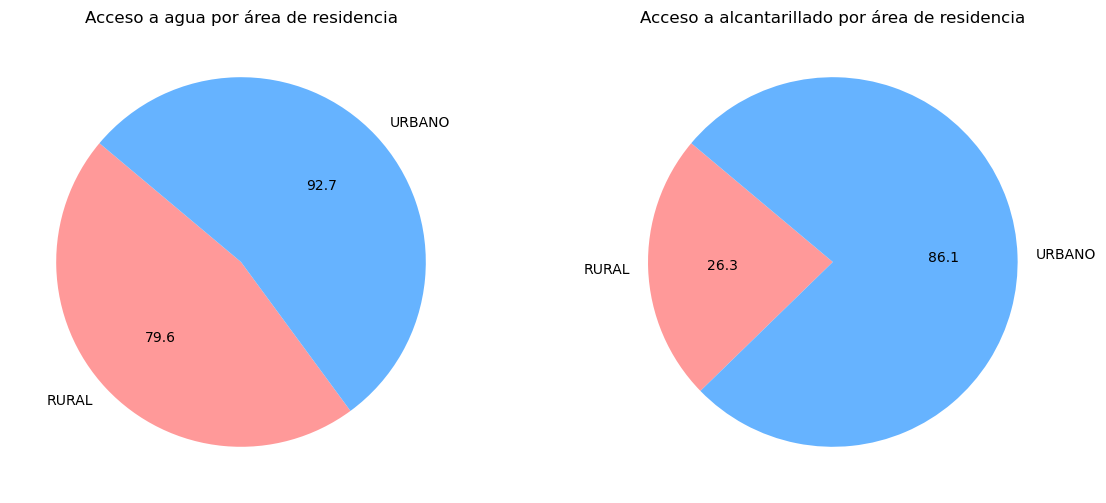

In [348]:
#### Gráfico de PIE

# Colores
colors = ['#ff9999', '#66b3ff']
def func(pct, all_values):
    absolute = pct / 100. * sum(all_values)
    return f'{absolute:.1f}'
    
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Primer gráfico
axs[0].pie(acceso_agua.SI, labels=['RURAL','URBANO'], colors=colors, autopct=lambda pct: func(pct, acceso_agua.SI), startangle=140)
axs[0].set_title('Acceso a agua por área de residencia')

# Segundo gráfico
axs[1].pie(acceso_alca.SI, labels=['RURAL','URBANO'], colors=colors, autopct=lambda pct: func(pct, acceso_alca.SI), startangle=140)
axs[1].set_title('Acceso a alcantarillado por área de residencia')

# Mostrando el gráfico
plt.show()

# Interpretación: 
# - El 92.7% de personas del ámbito urbano tienen acceso al servicio de agua, mientras que en el ámbito rural,el 79.6%.
# - El 86.1% de personas del ámbito urbano tienen acceso al servicio de alcantarillado, mientras que en el ámbito rural,apenas el 26.3%.

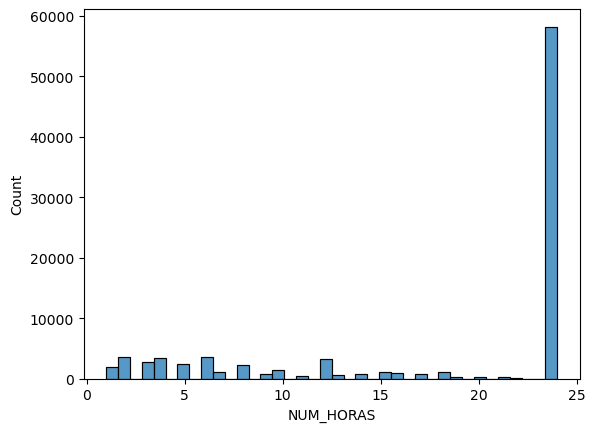

In [357]:
# Histograma de la continuidad
sns.histplot(bd_enapres_completa['NUM_HORAS'])
plt.show()

### Se puede visualizar que la mayor cantidad de personas tienen acceso a agua las 24 horas del día.

ALCA_RPA_LAB    SI
ESTRATO_LAB       
A             99.1
B             97.9
C             95.4
D             83.7
E             62.7


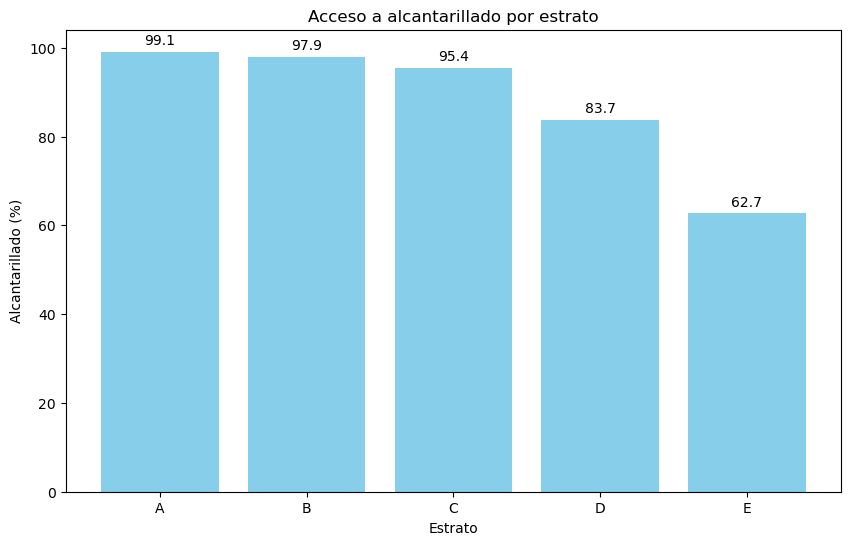

In [349]:
# Calculando el porcentaje de acceso a alcantarillado por estrato (Importante: corresponde sólo a ambito urbano)
acceso_alcantarillado_estrato = peso.distribution(bd_enapres_completa.groupby(['ESTRATO_LAB']),'ALCA_RPA_LAB').drop('NO',axis=1)
acceso_alcantarillado_estrato['SI'] = round(acceso_alcantarillado_estrato['SI']*100,1)
print(acceso_alcantarillado_estrato)

#### Gráfico de BARRAS
plt.figure(figsize=(10, 6))
plt.bar(['A','B','C','D','E'], acceso_alcantarillado_estrato.SI, color='skyblue')

# Eje x
plt.xlabel('Estrato') 
# Eje y
plt.ylabel('Alcantarillado (%)')  
# Titulo
plt.title('Acceso a alcantarillado por estrato') 

# Agregando etiqueta de valores
for i, value in enumerate(acceso_alcantarillado_estrato.SI): 
    plt.text(i, value + 1, f'{value:.1f}', ha='center', va='bottom')

# Mostrando el gráfico
plt.show()

# Interpretación: La población de estratos A tienen acceso a alcantarillado del 99.1%, mientras que los estratos E, tienen acceso a 62.7%

In [360]:
# Calculando el porcentaje de acceso a agua por región
acceso_agua_region = peso.distribution(bd_enapres_completa.groupby(['REGIONNATU_LAB']),'AGUA_RPA_LAB').drop('NO',axis=1)
acceso_agua_region['SI'] = round(acceso_agua_region['SI']*100,1)
print("----------")
print("Acceso a agua por región")
print(acceso_agua_region)

# Calculando el porcentaje de acceso a alcantarillado por región
acceso_alca_region = peso.distribution(bd_enapres_completa.groupby(['REGIONNATU_LAB']),'ALCA_RPA_LAB').drop('NO',axis=1)
acceso_alca_region['SI'] = round(acceso_alca_region['SI']*100,1)
print("----------")
print("Acceso a alcantarillado por región")
print(acceso_alca_region)

----------
Acceso a agua por región
AGUA_RPA_LAB      SI
REGIONNATU_LAB      
COSTA           91.7
SELVA           80.7
SIERRA          90.7
----------
Acceso a alcantarillado por región
ALCA_RPA_LAB      SI
REGIONNATU_LAB      
COSTA           84.6
SELVA           53.1
SIERRA          62.6


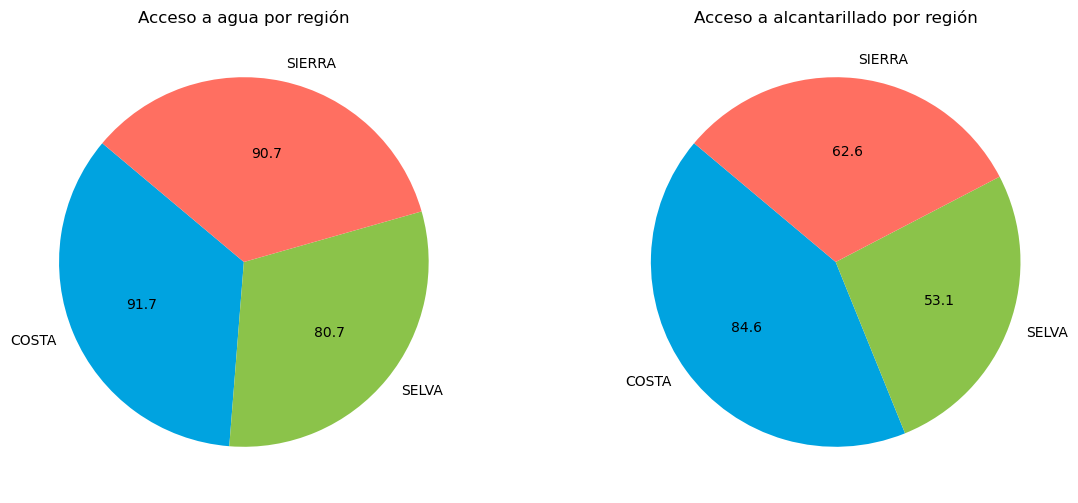

In [351]:
#### Gráfico de PIE

# Colores
colors = ['#00A3E0', '#8BC34A', '#FF6F61']
def func(pct, all_values):
    absolute = pct / 100. * sum(all_values)
    return f'{absolute:.1f}'
    
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Primer gráfico
axs[0].pie(acceso_agua_region.SI, labels=['COSTA','SELVA','SIERRA'], colors=colors, autopct=lambda pct: func(pct, acceso_agua_region.SI), startangle=140)
axs[0].set_title('Acceso a agua por región')

# Segundo gráfico
axs[1].pie(acceso_alca_region.SI, labels=['COSTA','SELVA','SIERRA'], colors=colors, autopct=lambda pct: func(pct, acceso_alca_region.SI), startangle=140)
axs[1].set_title('Acceso a alcantarillado por región')

# Mostrando el gráfico
plt.show()

# Interpretación: 
# - El menor porcentaje de cobertura de servicios corresponde a la selva, con 80.7% en agua y 53.1% en alcantarillado

In [352]:
# Calculando el porcentaje de acceso a agua área y nivel de cloro residual
acceso_agua_clora = peso.distribution(bd_enapres_completa.groupby(['NIVEL_CLORO_RESIDUAL_LAB','AREA_LAB']),'AGUA_RPA_LAB').drop('NO',axis=1)
acceso_agua_clora['SI'] = round(acceso_agua_clora['SI']*100,1)

# Interpretación:
#  - En el ámbito urbano, el 98.6% de la población accede a agua clorada (cloro residual >= 0.05 mg/L), mientras que el 88.4% accede a agua pero no clorada
#  - En el ámbito rural, el 92.7% de la población accede a agua clorada (cloro residual >= 0.05 mg/L), mientras que el 79.2% accede a agua pero no clorada
acceso_agua_clora

AGUA_RPA_LAB                         SI
NIVEL_CLORO_RESIDUAL_LAB AREA_LAB      
NO                       RURAL     79.2
                         URBANO    88.4
SI                       RURAL     92.7
                         URBANO    98.6

In [353]:
# Calculando la cantidad de población rural sin acceso a agua clorada
bd_pob_no_segura = bd_enapres_completa[(bd_enapres_completa.AGUA_RPA_LAB == 'SI') & (bd_enapres_completa.AREA_LAB == 'RURAL') & (bd_enapres_completa.NIVEL_CLORO_RESIDUAL_LAB == 'NO')] \
    .groupby('NOMBREDD').agg({'FACTOR':'sum'}).reset_index() \
    .rename(columns={'NOMBREDD':'DEPARTAMENTO','FACTOR':'POBLACION'}) \
    .sort_values(by='POBLACION', ascending=True)

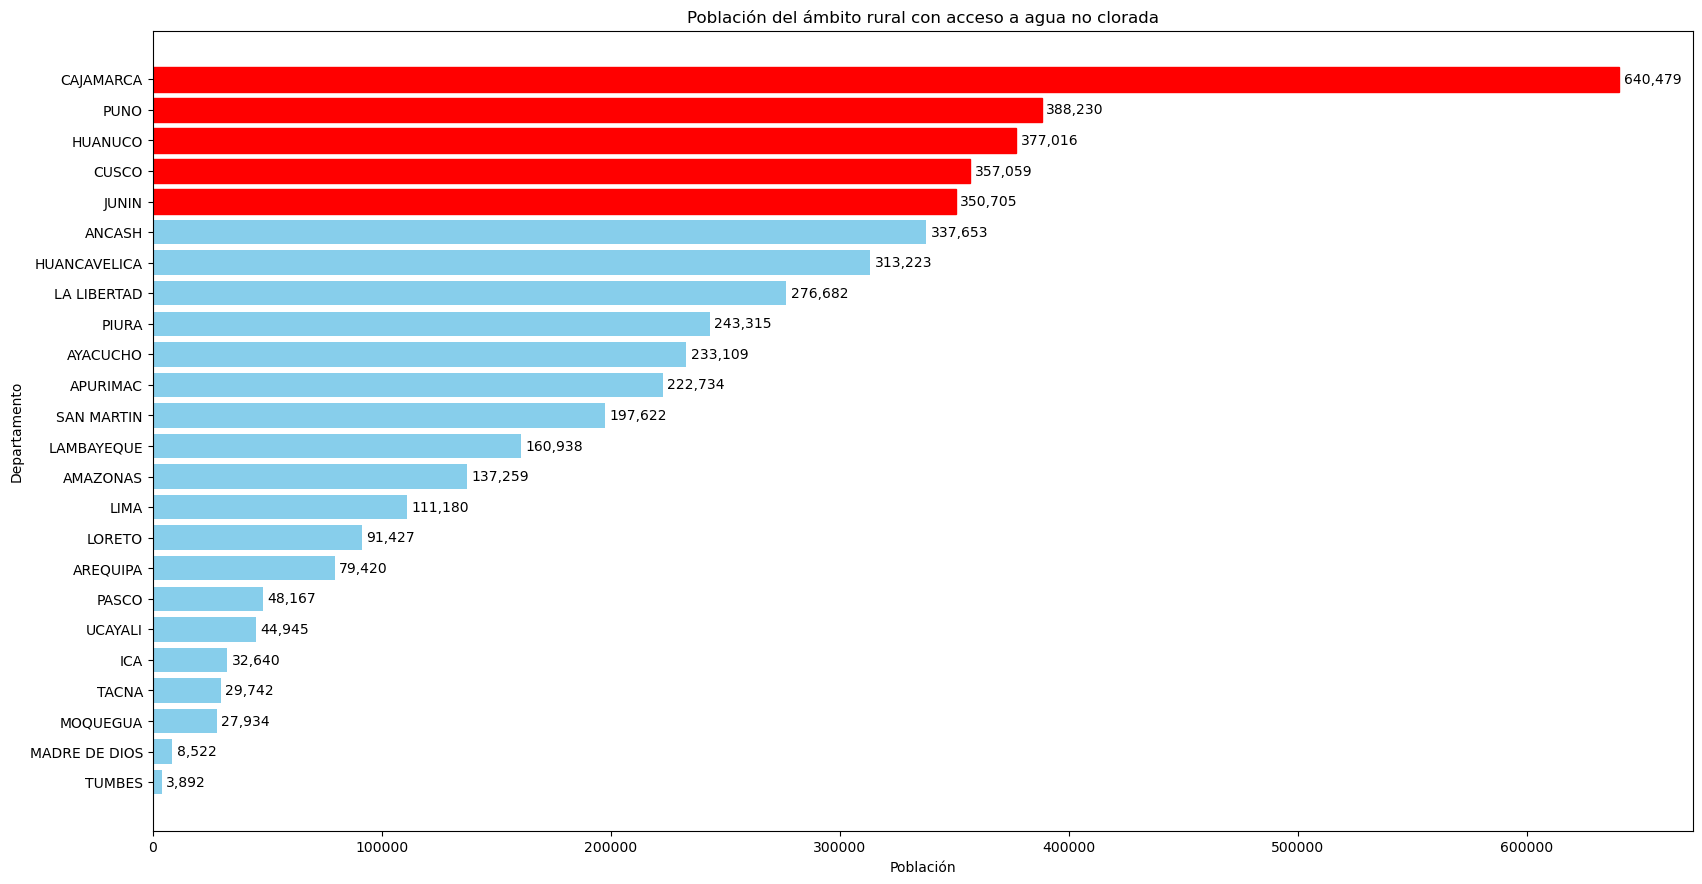

In [354]:
#### Gráfico de BARRAS

plt.figure(figsize=(14, 10))
bars = plt.barh(bd_pob_no_segura['DEPARTAMENTO'], bd_pob_no_segura['POBLACION'], color='skyblue')

# Pintar de rojo las primeras 5 barras
for i in range(-5,0):
    bars[i].set_color('red')

# Agregar etiqueta de valores a cada barra
for bar in bars:
    width = bar.get_width()
    plt.text(width + 2000, bar.get_y() + bar.get_height()/2,
             f'{width:,.0f}', 
             va='center', ha='left', fontsize=10, color='black')
    
# Añadir nombre de ejes (horizontal y vertical) y título
plt.xlabel('Población')
plt.ylabel('Departamento')
plt.title('Población del ámbito rural con acceso a agua no clorada')

# Ajustar márgenes
plt.subplots_adjust(left=0.2, right=1.3, top=0.9, bottom=0.1)

# Mostrando el gráfico
plt.show()

# Interpretación:
#   - El top 5 de departamentos con mayor población rural sin acceso a agua clorada son Cajamarca, Puno, Huánuco, Cusco y Junín, donde Cajamarca asciende a una población de 640 479